# Distilling Stable Diffusion to Neural Cellular Automata

This code is partly adapted from these two files:  
https://github.com/google-research/self-organising-systems/blob/master/notebooks/%CE%BCNCA_pytorch.ipynb  
https://github.com/ashawkey/stable-dreamfusion/blob/main/sd.py

In [32]:
from pathlib import Path
from datetime import datetime
from contextlib import nullcontext
import random
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [4]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from mediapy import VideoWriter as VW
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from tqdm import tnrange

In [5]:
from transformers import CLIPTextModel, CLIPTokenizer, logging
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, DDIMScheduler
from diffusers.utils.import_utils import is_xformers_available

from torch.cuda.amp import custom_bwd, custom_fwd 

In [6]:
class SpecifyGradient(torch.autograd.Function):
    @staticmethod
    @custom_fwd
    def forward(ctx, input_tensor, gt_grad):
        ctx.save_for_backward(gt_grad) 
        # we return a dummy value 1, which will be scaled by amp's scaler so we get the scale in backward.
        return torch.ones([1], device=input_tensor.device, dtype=input_tensor.dtype) 

    @staticmethod
    @custom_bwd
    def backward(ctx, grad_scale):
        gt_grad, = ctx.saved_tensors
        gt_grad = gt_grad * grad_scale
        return gt_grad, None

In [7]:
device = "cuda" #"cpu"
use_bf = True
ctx = torch.amp.autocast(device_type=device, dtype=torch.bfloat16) if use_bf else nullcontext() #  # 

In [8]:
model_key = "stabilityai/stable-diffusion-2-1-base"

vae = AutoencoderKL.from_pretrained(model_key, subfolder="vae").to(device)
tokenizer = CLIPTokenizer.from_pretrained(model_key, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_key, subfolder="text_encoder").to(device)
unet = UNet2DConditionModel.from_pretrained(model_key, subfolder="unet").to(device)

#if is_xformers_available():
#    unet.enable_xformers_memory_efficient_attention()

scheduler = DDIMScheduler.from_pretrained(model_key, subfolder="scheduler")
#DPMSolverMultistepScheduler
# scheduler = PNDMScheduler.from_pretrained(model_key, subfolder="scheduler")

num_train_timesteps = scheduler.config.num_train_timesteps
min_step = int(num_train_timesteps * 0.02)
max_step = int(num_train_timesteps * 0.98)
alphas = scheduler.alphas_cumprod.to(device) # for convenience

In [9]:
with torch.no_grad():
    enc = vae.encode(torch.rand((1,3,512,512), device=device) * 2 - 1)

In [10]:
enc.latent_dist.std.max()

tensor(0.0053, device='cuda:0')

In [11]:
enc.latent_dist.sample()[0, :, 0, 0]

tensor([-0.8998,  0.7290,  1.3046, -1.5233], device='cuda:0')

In [12]:
vae.config.scaling_factor

0.18215

In [13]:
vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
vae_scale_factor

8

In [14]:
def get_text_embeds(prompt, negative_prompt):
    # prompt, negative_prompt: [str]

    # Tokenize text and get embeddings
    text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Do the same for unconditional embeddings
    uncond_input = tokenizer(negative_prompt, padding='max_length', max_length=tokenizer.model_max_length, return_tensors='pt')

    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Cat for final embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings

In [15]:
get_text_embeds(["gaming"], ["not gaming ever no matter what"]).shape

torch.Size([2, 77, 1024])

In [16]:
def encode_imgs(imgs):
    # imgs: [B, 3, H, W]
    
    # normalize [0,1] to [-1, 1]
    imgs = 2 * imgs - 1

    posterior = vae.encode(imgs).latent_dist
    latents = posterior.sample() * vae.config.scaling_factor

    return latents

In [17]:
def decode_latents(latents):

    latents = 1 / vae.config.scaling_factor * latents

    with torch.no_grad():
        imgs = vae.decode(latents).sample

    # remap [-1, 1] to [0, 1]
    imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

In [18]:
!ls ~/Downloads

 336330840_6706284996055180_8781873629435474519_n.mp4
 azcopy_linux_amd64_10.17.0.tar.gz
 cuda_11.8.0_520.61.05_linux.run
 cuda_12.1.0_530.30.02_linux.run
 IMG_0162.jpg
 LLaMA
 Mambaforge-pypy3-Linux-x86_64.sh
 NVIDIA-Linux-x86_64-520.56.06.run
 NVIDIA-Linux-x86_64-525.89.02.run
 p_sim_long_3_slow.npy.zip
'raindrops(1).gif'
 steam_latest.deb
 wdas_cloud_quarter.nvdb
 μNCA_pytorch.ipynb


In [19]:
def show(t):
    plt.imshow(t.permute(1,2,0).cpu().numpy())

In [20]:
from PIL import Image
import requests
from torchvision.io import read_image
import torchvision.transforms as transforms

image = Image.open("/home/pwhiddy/Downloads/IMG_0162.jpg")

transform = transforms.Compose([
transforms.PILToTensor(),
transforms.Resize((512,512))
])

torch_image = transform(image).to(device)

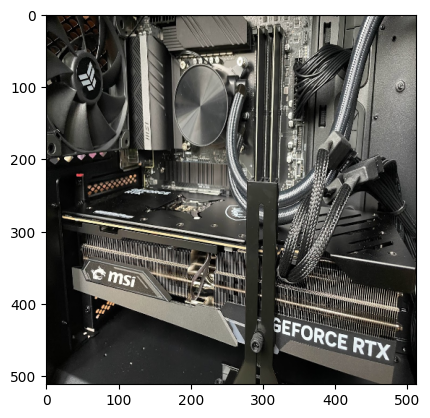

In [21]:
show(torch_image)

In [22]:
torch_image.unsqueeze(0).shape

torch.Size([1, 3, 512, 512])

In [23]:
with torch.no_grad():
    latents = encode_imgs(torch_image.unsqueeze(0) / 255.0)

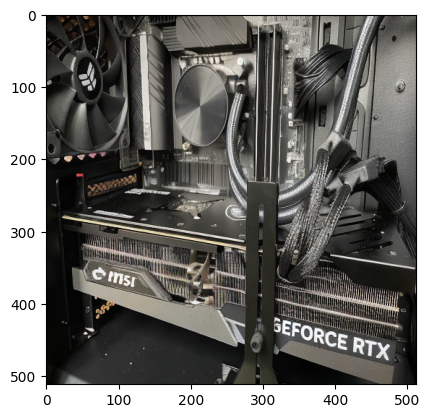

In [24]:
show(decode_latents(latents)[0])

In [25]:
latents.shape

torch.Size([1, 4, 64, 64])

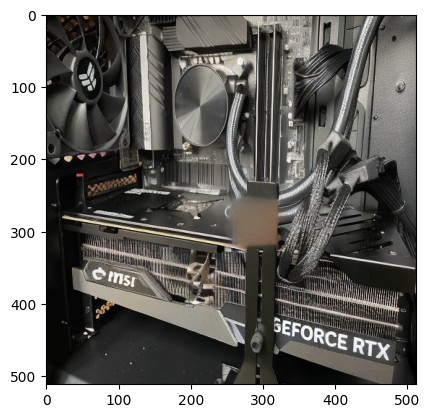

In [26]:
messed_latent = latents.clone()
messed_latent[:, :, 32:40,32:40] = 0#torch.randn(8,8)*0.5
show(decode_latents(messed_latent)[0])

In [27]:
latents.mean()

tensor(-0.1106, device='cuda:0')

In [28]:
latents.std()

tensor(0.7593, device='cuda:0')

In [29]:
class SpecifyGradient(torch.autograd.Function):
    @staticmethod
    @custom_fwd
    def forward(ctx, input_tensor, gt_grad):
        ctx.save_for_backward(gt_grad) 
        # we return a dummy value 1, which will be scaled by amp's scaler so we get the scale in backward.
        return torch.ones([1], device=input_tensor.device, dtype=input_tensor.dtype) 

    @staticmethod
    @custom_bwd
    def backward(ctx, grad_scale):
        gt_grad, = ctx.saved_tensors
        gt_grad = gt_grad * grad_scale
        return gt_grad, None

In [30]:

def sd_latent_grad_loss(text_embeddings, pred_latent, guidance_scale=100):

    t = torch.randint(min_step, max_step + 1, [1], dtype=torch.long, device=device)
    
    # predict the noise residual with unet, NO grad!
    with torch.no_grad():
        # add noise
        noise = torch.randn_like(pred_latent)
        latents_noisy = scheduler.add_noise(pred_latent, noise, t)
        # pred noise
        latent_model_input = torch.cat([latents_noisy] * 2)
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance (high scale from paper!)
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_text + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # w(t), sigma_t^2
    w = (1 - alphas[t])
    # w = alphas[t] ** 0.5 * (1 - alphas[t])
    grad = w * (noise_pred - noise)

    # clip grad for stable training?
    grad = grad.clamp(-10, 10)
    #grad = torch.nan_to_num(grad)

    with torch.no_grad():
        grad_mag = grad.abs().mean()
    #print(f"grad shape: {grad.shape}")

    # since we omitted an item in grad, we need to use the custom function to specify the gradient
    loss = SpecifyGradient.apply(pred_latent, grad) 

    #print(f"loss shape: {loss.shape}")

    return loss, grad_mag



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 18.18it/s]


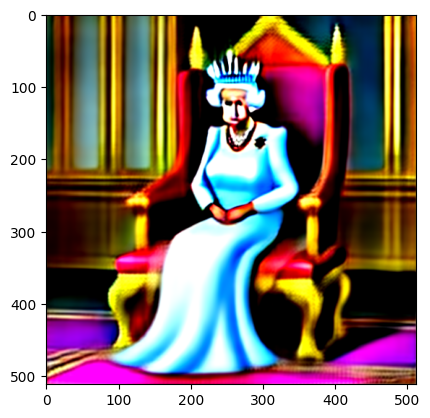

In [53]:
# dummy img training (random t)
init_latent = torch.randn(1,4,64,64, device=device, requires_grad=True)
#init_img.mean()
batch_size = 1
text_embeds = get_text_embeds(["the royal queen in her throne"]*batch_size, [""]*batch_size) # get_text_embeds(["raindrops on glass"]*batch_size, [""]*batch_size)#
opt_t = torch.optim.Adam([init_latent], 0.1) # torch.optim.SGD([init_latent], 0.3) #
for i in tqdm(range(200)):
    loss, grad_mag = sd_latent_grad_loss(text_embeds, init_latent, guidance_scale=150)
    opt_t.zero_grad()
    loss.backward()
    opt_t.step()
    
result = decode_latents(init_latent.detach())[0]
show(result)

In [51]:
init_latent.std()

tensor(1.9200, device='cuda:0', grad_fn=<StdBackward0>)

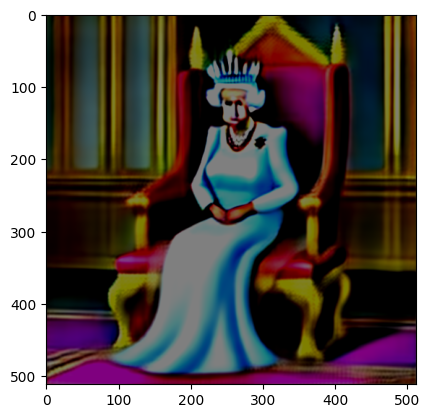

In [55]:
show(decode_latents(init_latent.detach())[0]*0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


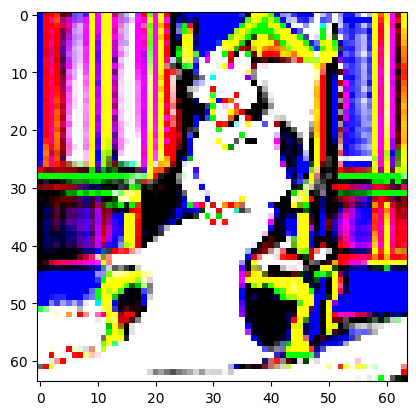

In [58]:
show(init_latent[0].detach())

In [ ]:
# μNCA 
# adapted from https://github.com/google-research/self-organising-systems/blob/master/notebooks/%CE%BCNCA_pytorch.ipynb

side = torch.tensor([[0.0, 0.0,0.0], [2.0,-2.0,0.0], [0.0, 0.0,0.0]]) 
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]) 
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

# filters = [lap]*2+[sobel_x]*1+[sobel_x.T]*1  # 68 params
# filters = [lap]*2+[sobel_x]*2+[sobel_x.T]*2 # 150 params
# filters = [lap]*4+[sobel_x]*2+[sobel_x.T]*2  # 264 params
#filters = [lap]*4+[sobel_x]*4+[sobel_x.T]*4  # 588 params
filters = [lap]*8+[sobel_x]*4+[sobel_x.T]*8  # 1620 params
#filters = [lap]*12+[sobel_x]*12+[sobel_x.T]*12  # 5220 params

filters = torch.stack(filters)[:,None]
filters = filters.to(device)
CHN = len(filters)

class CA(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(CHN, 4*CHN+1, 1, 1)*1e-3)

    def to_latent(self, x):
        return x[...,:4,:,:]
    
    def to_rgb(self, x):
        return decode_latents(self.to_latent(x))

    def forward(self, x, update_rate=1.0):
        y = torch.nn.functional.pad(x, [1, 1, 1, 1], 'circular')
        y = torch.nn.functional.conv2d(y, filters, groups=y.shape[1])
        y = torch.cat([x, y], 1)
        y = y = torch.cat([y, y.abs()], 1)
        w, b = self.w[:,:-1], self.w[:,-1,0,0]
        y = torch.nn.functional.conv2d(y, w, b)
        if update_rate<1.0:
            y *= (torch.rand(*y.shape, device=device)+update_rate).floor()
        #return x+y, y
        return y

print('param count:', sum(p.numel() for p in CA().parameters()))

In [23]:

def make_vid(out_path, ca, iters, x, y):
    step_n = 1
    with VW(out_path, shape=(x,y)) as w, torch.no_grad():
        s = m_state()["state"]
        for k in range(iters):
            img = ca.to_rgb(s[:1])[0].permute(1,2,0).cpu().numpy()
            #print(img.mean())
            w.add_image(img)
            #print(norm_loss(x, 1))
            for i in range(step_n):
                s = s + ca(s, update_rate=0.5)


In [ ]:
# todo
# 1. increase model capacity
# 2. (done) use pool to reinit from for long term stability
# 3. use simple ca model?
# 4. make memory usage less?
# 5. is quality affected by using fp/bf16?
# 6. increase resolution

def make_state(batch, channels, x, y):
    return {"state": torch.rand(batch_size, channels, x, y, device=device)*0.25, "steps": 0}
    #return {"state": torch.zeros(batch_size, channels, x, y, device=device), "steps": 0}

"""
def norm_loss(cur_img, scale):
    #above = F.relu( cur_img - 1 ) ** 2
    #below = F.relu( -cur_img ) ** 2
    #return scale * (above.mean() + below.mean())
    return scale * ((cur_img - 0.5) ** 2).mean() # for testing for stable loss
"""

batch_size = 2
pool_size = 32
reset_prob = 0.04
ca_steps = 20 # 40
channels = 20 # 12

iterations = 2500
#norm_loss_scale = 10
#sd_loss_scale = 0.005

dim = 64 # 256

seed = 0
random.seed(seed)
torch.manual_seed(seed)
ca =  CA().to(device) #  CAModel().to(device)
text_embeds = get_text_embeds(["raindrops on glass"]*batch_size, [""]*batch_size)  # 
opt = torch.optim.Adam(ca.parameters(), 1e-3)

m_state = lambda : make_state(batch_size, channels, dim, dim)
pool = [m_state() for _ in range(pool_size)]

run_dir = Path("output/{:%Y_%m_%d_%H_%M_%S}".format(datetime.now()))
run_dir.mkdir(exist_ok=True, parents=True)

for i in tnrange(iterations):
    
    track_grad_mag = 0
    track_latent_mean = 0
    track_latent_std = 0
    #track_norm_loss = 0
    loss_steps = 0
    for p in range(pool_size):
        # gradually increase the number of steps so gradients don't explode
        if random.uniform(0, 1) < reset_prob or i < pool[p]["steps"]:
            pool[p] = m_state()
        else:
            pool[p]["state"] = pool[p]["state"].detach()
        state = pool[p]["state"]
        
        for step in range(ca_steps):
            state = state + ca(state, update_rate=0.5)
            
        latents = ca.to_latent(state)
        
        with torch.no_grad():
            track_latent_mean += latents.mean().item()
            track_latent_std += latents.std().item()
                
        with ctx:
            loss, grad_mag = sd_latent_grad_loss(
                text_embeds, latents, guidance_scale=200
            )
        
        
        #loss = sd_loss_scale * sd_loss

        
        # MSE loss for going outside of pixel range
        #total_norm_loss = norm_loss(pixels, norm_loss_scale)
        #loss += total_norm_loss

        #track_norm_loss += total_norm_loss.item()
        track_grad_mag += grad_mag.item()
        loss_steps += 1
        
        loss.backward()
        pool[p]["state"] = state
        pool[p]["steps"] += ca_steps
        
    print(f"i{i} grad_mag: {track_grad_mag / loss_steps:06f} " + 
          f"latent_mean: {track_latent_mean / loss_steps:06f} " +
          f"latent_std: {track_latent_std / loss_steps:06f} " +
          f"oldest state: {max([s['steps'] for s in pool])}")
    opt.step()
    opt.zero_grad()
    
    # save video + checkpoint every 10 iterations (this can add up quickly)
    if i % 10 == 0:
        save_dir = run_dir / "checkpoints"
        save_dir.mkdir(exist_ok=True, parents=True)
        save_path = save_dir / f"run-{i:06d}.pt"
        torch.save(ca, save_path)
        vid_dir = run_dir / "states" 
        vid_dir.mkdir(exist_ok=True, parents=True)
        vid_path = vid_dir / f"run-{i:06d}.mp4"
        make_vid(vid_path, ca, max([p["steps"] for p in pool]), 512, 512)


  0%|          | 0/2500 [00:00<?, ?it/s]

i0 step19 grad_mag: 1.372498 latent_mean: 0.123627 latent_std: 0.079509 oldest state: 20
i1 step19 grad_mag: 1.256228 latent_mean: 0.125520 latent_std: 0.187424 oldest state: 20
i2 step19 grad_mag: 1.197802 latent_mean: 0.117823 latent_std: 0.419248 oldest state: 20
i3 step19 grad_mag: 1.065340 latent_mean: 0.102726 latent_std: 0.869328 oldest state: 20
i4 step19 grad_mag: 1.003321 latent_mean: -0.057884 latent_std: 1.193768 oldest state: 20
i5 step19 grad_mag: 1.247370 latent_mean: -0.248566 latent_std: 1.622495 oldest state: 20
i6 step19 grad_mag: 1.054881 latent_mean: -0.185512 latent_std: 1.011826 oldest state: 20
i7 step19 grad_mag: 1.026389 latent_mean: -0.157318 latent_std: 0.718270 oldest state: 20
i8 step19 grad_mag: 1.037127 latent_mean: -0.154584 latent_std: 0.573678 oldest state: 20
i9 step19 grad_mag: 1.023230 latent_mean: -0.164851 latent_std: 0.496736 oldest state: 20
i10 step19 grad_mag: 1.172223 latent_mean: -0.183958 latent_std: 0.462816 oldest state: 20
i11 step19 gr

In [ ]:
show(ca.to_rgb(state)[0].detach())

In [ ]:
ca.to_rgb(state)[0].mean()

In [11]:
class VideoWriter:
    def __init__(self, filename="_autoplay.mp4", fps=30.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)

    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1) * 255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()
        if self.params["filename"] == "_autoplay.mp4":
            self.show()

    def show(self, **kw):
        self.close()
        fn = self.params["filename"]
        display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
    def __init__(self, *a, fade_len=1.0, **kw):
        super().__init__(*a, **kw)
        self._intro = []
        self._outro = []
        self.fade_len = int(fade_len * self.params["fps"])

    def add(self, img):
        if len(self._intro) < self.fade_len:
            self._intro.append(img)
            return
        self._outro.append(img)
        if len(self._outro) > self.fade_len:
            super().add(self._outro.pop(0))

    def close(self):
        for t in np.linspace(0, 1, len(self._intro)):
            img = self._intro.pop(0) * t + self._outro.pop(0) * (1.0 - t)
            super().add(img)
        super().close()


In [27]:
step_n = 1

with LoopWriter('final_ca.mp4', fade_len=0.0) as vid, torch.no_grad():
    x = make_state(1, 20, 64, 64)["state"] #m_state()["state"]
    for k in tnrange(200, leave=False):
        img = ca.to_rgb(x)[0].detach().permute(1,2,0).cpu().numpy()
        img = np.dot(img, [0.2989, 0.5870, 0.1140])
        vid.add(img)
        #print(norm_loss(x, 1))
        for i in range(step_n):
            x = x + ca(x, update_rate=0.5)
vid.show()
# video below was from a run with different parameters

  0%|          | 0/200 [00:00<?, ?it/s]